<a href="https://colab.research.google.com/github/Jannyney/ImageCaptioningThai/blob/main/Image_Captioning_Thai_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image captioning with visual attention in Thai



In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

## Download file from Kaggle
https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

In [ ]:
! mkdir train

In [ ]:
! unzip flickr8k.zip -d train

##Prepare the data

In [ ]:
image_folder = '/gdrive/MyDrive/Kaggle/train/Images/'
PATH = os.path.abspath('.') + image_folder

In [ ]:
annotation_file = '/content/gdrive/MyDrive/Kaggle/train/caption_th.txt'

In [ ]:
import pandas as pd
import csv
import glob

In [ ]:
with open(annotation_file, 'r') as f:
    next(f)
    annotations = csv.reader(f)
    annotations = pd.DataFrame(annotations, columns=['image','caption_th'])

In [ ]:
len(annotations)

40455

In [ ]:
annotations.head(n=10)

,image,caption_th
0,1000268201_693b08cb0e.jpg,เด็กในชุดสีชมพูกําลังปีนขึ้นบันไดในทางเข้า
1,1000268201_693b08cb0e.jpg,เด็กผู้หญิงกําลังเข้าไปในตึกไม้
2,1000268201_693b08cb0e.jpg,เด็กผู้หญิงกําลังปีนเข้าไปในบ้านเด็กเล่น
3,1000268201_693b08cb0e.jpg,เด็กหญิงตัวเล็ก ๆ ปีนบันไดไปที่หอละครของเธอ
4,1000268201_693b08cb0e.jpg,เด็กผู้หญิงในชุดสีชมพู เข้าไปในกระท่อมไม้
5,1001773457_577c3a7d70.jpg,สุนัขสีดําและสุนัขลายจุดกําลังต่อสู้
6,1001773457_577c3a7d70.jpg,สุนัขผิวดําและสุนัขตัวร้ายที่เล่นกันบนถนน
7,1001773457_577c3a7d70.jpg,สุนัขสีดําและสุนัขสีขาวที่มีจุดสีน้ําตาลกําลัง...
8,1001773457_577c3a7d70.jpg,สุนัขสองตัวที่มีสายพันธุ์ที่แตกต่างกันมองกันบนถนน
9,1001773457_577c3a7d70.jpg,สุนัขสองตัวบนทางเท้าเคลื่อนที่เข้าหากัน


In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in zip(annotations['image'],annotations['caption_th']):
  #caption = f"<start> {val[1]} <end>"
  caption = f"{val[1]}"
  #image_path = PATH + 'images_' + '%012d.jpg' % (val[0])
  image_path = "{}{}".format(PATH,val[0])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
#random.shuffle(image_paths)

# Total 8091 images
# Each image has 5 captions
# Total is 40455
train_image_paths = image_paths[:]
print(len(train_image_paths))

8091


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

เด็กในชุดสีชมพูกําลังปีนขึ้นบันไดในทางเข้า


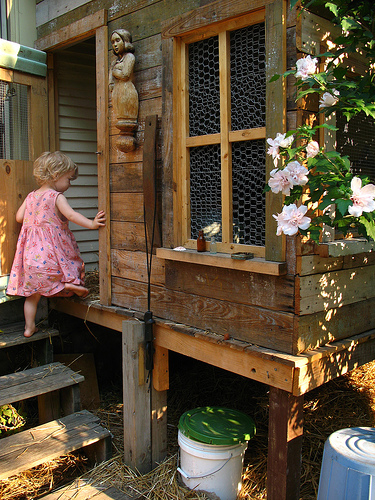

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Use InceptionV3 (which is pretrained on Imagenet) to classify each image. Extract features from the last convolutional layer.

First, convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. 
The shape of the output of this layer is ```8x8x2048```. 
Use the last convolutional layer because of using ```attention```. 
Don't perform this initialization during training because it could become a bottleneck.

* Forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Caching the features extracted from InceptionV3

Pre-process each image with InceptionV3 and cache the output to disk. 




In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 506/506 [37:36<00:00,  4.46s/it]


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [ ]:
!pip install pythainlp
!pip install stop_words
import pythainlp
from pythainlp import word_tokenize
#from pythainlp.corpus import stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words

     |████████████████████████████████| 11.0MB 16.3MB/s 
     |████████████████████████████████| 747kB 44.3MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32913 sha256=8bfb917c128355cb3cd0ed71a095d355c9a723e3e92e1d635f69b1015c1f0549
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from pythainlp.corpus import thai_stopwords

In [ ]:
print(type(train_captions))
print(len(train_captions))

<class 'list'>
40455


### Tokenize word

In [ ]:
!pip install pythainlp[attacut]

     |████████████████████████████████| 1.3MB 31.8MB/s 
     |████████████████████████████████| 481kB 57.9MB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 645kB 46.7MB/s 
     |████████████████████████████████| 51kB 10.0MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=162e929fb3ca058d54f76332c4a0199798c49ab7d36aba9d47f790301090ef60
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from pythainlp.tokenize import word_tokenize 
from collections import Counter, OrderedDict
import itertools

In [ ]:
print(train_captions[0])

เด็กในชุดสีชมพูกําลังปีนขึ้นบันไดในทางเข้า


In [ ]:
import re
for i in range(len(train_captions)):
    train_captions[i] = re.sub(r',','', train_captions[i])  # remove comma from each sentence

In [ ]:
thai_texts = []

for line in train_captions:
  thai_text = line.replace('\n','') 
  thai_texts.append(thai_text) # Append each sentence to the list

print(thai_texts[0])

เด็กในชุดสีชมพูกําลังปีนขึ้นบันไดในทางเข้า


In [ ]:
thai_text_tokenizes = []

for i,thai_text in enumerate(thai_texts):
  thai_text_tokenizes.append(word_tokenize(thai_text,engine='newmm')) # tokenize each word
  print(f"{i}/{len(thai_texts)}", end='\r')

In [ ]:
thai_text_tokenizes_merge = list(itertools.chain(*thai_text_tokenizes))
thai_counter = Counter(thai_text_tokenizes_merge)

In [ ]:
thai_vocab_index_to_word = {0:'<start>', 1:'<end>'}
thai_vocab_word_to_index = {'<start>':0, '<end>':1}

for i, word in enumerate(thai_counter): 
  thai_vocab_index_to_word[i+2] = word # index to word
  thai_vocab_word_to_index[word] = i+2 # word to index

In [ ]:
thai_vocab_index_to_word

{0: '<start>',
 1: '<end>',
 2: 'เด็ก',
 3: 'ใน',
 4: 'ชุด',
 5: 'สีชมพู',
 6: 'กํา',
 7: 'ลัง',
 8: 'ปีน',
 9: 'ขึ้น',
 10: 'บันได',
 11: 'ทางเข้า',
 12: 'เด็กผู้หญิง',
 13: 'เข้าไป',
 14: 'ตึก',
 15: 'ไม้',
 16: 'บ้าน',
 17: 'เล่น',
 18: 'เด็กหญิง',
 19: 'ตัวเล็ก',
 20: ' ',
 21: 'ๆ',
 22: 'ไป',
 23: 'ที่',
 24: 'หอ',
 25: 'ละคร',
 26: 'ของ',
 27: 'เธอ',
 28: 'กระท่อม',
 29: 'สุนัข',
 30: 'สีด',
 31: 'ํา',
 32: 'และ',
 33: 'ลาย',
 34: 'จุ',
 35: 'ดก',
 36: 'ต่อสู้',
 37: 'ผิว',
 38: 'ดํา',
 39: 'ตัว',
 40: 'ร้าย',
 41: 'กัน',
 42: 'บน',
 43: 'ถนน',
 44: 'สี',
 45: 'ขาว',
 46: 'มี',
 47: 'จุด',
 48: 'น้ํา',
 49: 'ตา',
 50: 'ลก',
 51: 'จ้องมอง',
 52: 'สอง',
 53: 'สายพันธุ์',
 54: 'แตก',
 55: 'ต่างกัน',
 56: 'มอง',
 57: 'ทางเท้า',
 58: 'เคลื่อนที่',
 59: 'เข้าหา',
 60: 'ปกคลุม',
 61: 'ด้วย',
 62: 'นั่ง',
 63: 'อยู่',
 64: 'หน้า',
 65: 'รุ้ง',
 66: 'ด้วยมือ',
 67: 'ชาม',
 68: 'สายรุ้ง',
 69: 'ขนาดใหญ่',
 70: 'ทุ่งหญ้า',
 71: 'กับ',
 72: 'ผ้าใบ',
 73: 'ข้างหน้า',
 74: 'หางเปีย',
 75: 'ตรง

In [ ]:
print(len(thai_vocab_index_to_word.keys())) #6867

6867


In [ ]:
def convert_sentence_to_index_token(sentence: str):
  word_in_sentence = ['<start>']+ word_tokenize(sentence, engine='newmm') + ['<end>']  # tokenize word in sentence ['cat', 'has']
  word_index = [thai_vocab_word_to_index[word] for word in word_in_sentence] # e.g. cat, thai_vocab[cat] = 2
  return word_in_sentence, word_index

In [ ]:
# example
word_in_sentence, word_index = convert_sentence_to_index_token(train_captions[0])

In [ ]:
# example
for i, word in enumerate(word_in_sentence):
  print(word, word_index[i])

<start> 0
เด็ก 2
ใน 3
ชุด 4
สีชมพู 5
กํา 6
ลัง 7
ปีน 8
ขึ้น 9
บันได 10
ใน 3
ทางเข้า 11
<end> 1


In [164]:
train_seqs = []
sentence_lis = []
for i in train_captions:
  word_in_sentence, word_index = convert_sentence_to_index_token(i)
  for j, word in enumerate(word_in_sentence):
    sentence_lis.append(word_index[j])
  train_seqs.append(sentence_lis) # [['1','5'],[...],..]
  sentence_lis = []
#print(train_seqs)

In [ ]:
print(len(train_seqs))

40455


In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Words from the vocabulary
top_k = len(thai_vocab_index_to_word.keys())
# top_k = 6867

In [ ]:
# Pad each vector to the max_length of the captions (to be matrix)
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print(cap_vector)

[[   0    2    3 ...    0    0    0]
 [   0   12    6 ...    0    0    0]
 [   0   12    6 ...    0    0    0]
 ...
 [   0  628    3 ...    0    0    0]
 [   0  212    8 ...    0    0    0]
 [   0 2092    8 ...    0    0    0]]


In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs) #43
print(max_length)

43


## Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

## Create a tf.data dataset for training


Create a `tf.data` dataset to use for training your model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model


* The features from the lower convolutional layer of InceptionV3 gives us a vector of shape (8, 8, 2048).
* Squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
import tensorflow as tf
class Net(tf.keras.Model):
  """A simple linear model."""

  def __init__(self):
    super(Net, self).__init__()
    self.l1 = tf.keras.layers.Dense(5)

  def call(self, x):
    return self.l1(x)

In [ ]:
net = Net()

## Training

* Extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0726
Epoch 1 Batch 100 Loss 1.6566
Epoch 1 Batch 200 Loss 1.3080
Epoch 1 Batch 300 Loss 1.0373
Epoch 1 Batch 400 Loss 1.0056
Epoch 1 Batch 500 Loss 1.0468
Epoch 1 Batch 600 Loss 1.0705
Epoch 1 Batch 700 Loss 0.9575
Epoch 1 Batch 800 Loss 1.1006
Epoch 1 Batch 900 Loss 0.8022
Epoch 1 Batch 1000 Loss 1.1372
Epoch 1 Batch 1100 Loss 0.8612
Epoch 1 Batch 1200 Loss 1.1374
Epoch 1 Batch 1300 Loss 0.8003
Epoch 1 Batch 1400 Loss 1.0433
Epoch 1 Batch 1500 Loss 0.8657
Epoch 1 Batch 1600 Loss 0.7952
Epoch 1 Batch 1700 Loss 0.8253
Epoch 1 Batch 1800 Loss 0.9798
Epoch 1 Batch 1900 Loss 0.7442
Epoch 1 Batch 2000 Loss 0.8853
Epoch 1 Loss 1.046829
Time taken for 1 epoch 316.33 sec

Epoch 2 Batch 0 Loss 1.4488
Epoch 2 Batch 100 Loss 1.0134
Epoch 2 Batch 200 Loss 1.0017
Epoch 2 Batch 300 Loss 0.8242
Epoch 2 Batch 400 Loss 0.8179
Epoch 2 Batch 500 Loss 0.9723
Epoch 2 Batch 600 Loss 0.8072
Epoch 2 Batch 700 Loss 0.7024
Epoch 2 Batch 800 Loss 0.8969
Epoch 2 Batch 900 Loss 0.8865
Epoch 

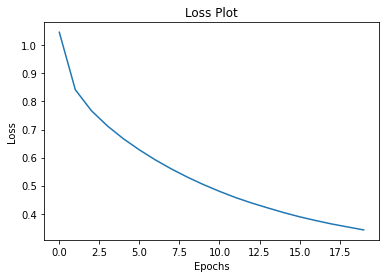

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder_2.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([thai_vocab_word_to_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder_2(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(thai_vocab_index_to_word[predicted_id])

        if thai_vocab_index_to_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

##Add Thai Font

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

In [ ]:
# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula')

/content/gdrive/MyDrive/Kaggle/train/Images/2490365757_b869282cb3.jpg
Real Caption: ชาย คน หนึ่ง กํา ลัง คุกเข่า ข้าง ขาตั้ง กล้อง และ ดอก ทิวลิป <end>
Prediction Caption: เด็กผู้ชาย อยู่ บน ขาตั้ง <end>


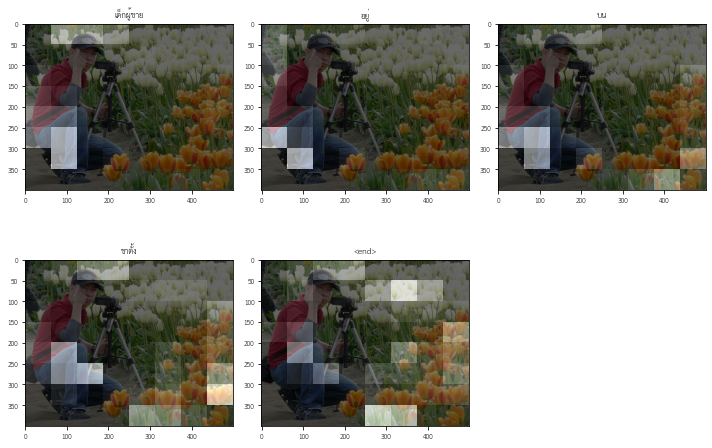

In [162]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([thai_vocab_index_to_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print(image)
Image.open(image)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

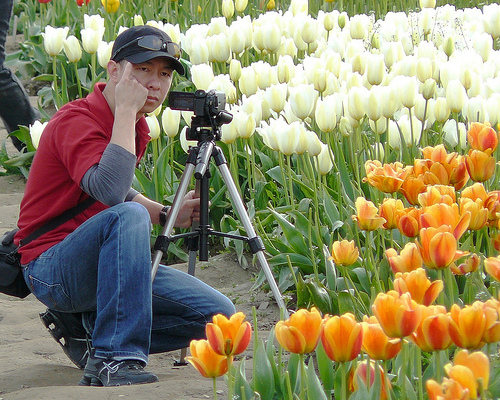

In [163]:
Image.open("/content/gdrive/MyDrive/Kaggle/train/Images/2490365757_b869282cb3.jpg")

## Try with picture from the Internet


Prediction Caption: เด็กน้อย กระโดด ลง จาก แทรมโพลีน <end>


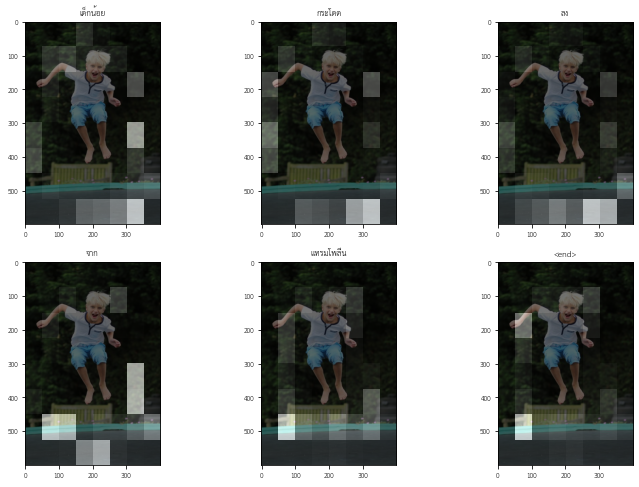

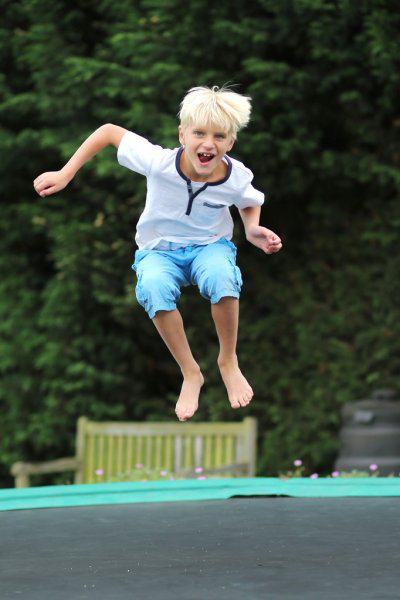

In [117]:
image_url = 'http://st.depositphotos.com/3240685/4267/i/450/depositphotos_42671193-Boy-jumping-high-in-the-sky-on-trampoline.jpg'
image_extension = image_url[-7:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: ผู้หญิง ที่ มี ตา กว้าง   ยก มือขึ้น <end>


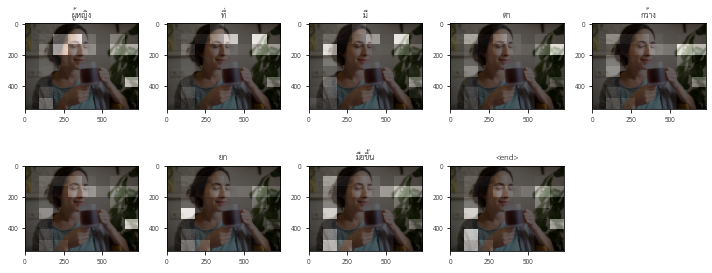

In [ ]:
image_url = 'https://post.healthline.com/wp-content/uploads/2020/03/Female_Drinking_Coffee_732x549-thumbnail-732x549.jpg'
image_extension = image_url[-6:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)


##Save Model


In [ ]:
import pickle

In [ ]:
with open("index2word","wb") as f:
    pickle.dump(thai_vocab_index_to_word,f)

In [ ]:
with open("word2index","wb") as f:
    pickle.dump(thai_vocab_word_to_index,f)

In [ ]:
encoder.save_weights('/content/gdrive/MyDrive/Kaggle/saved_model/encoder')

In [ ]:
decoder.save_weights('/content/gdrive/MyDrive/Kaggle/saved_model/decoder')

In [ ]:
encoder_2 = CNN_Encoder(embedding_dim)

In [ ]:
decoder_2 = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder_2.load_weights("/content/gdrive/MyDrive/Kaggle/saved_model/encoder")

In [ ]:
decoder_2.load_weights("/content/gdrive/MyDrive/Kaggle/saved_model/decoder")